In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'phase_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros
# First source, on axis
source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': toliman_settings
            }


In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)#,multi=False)


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


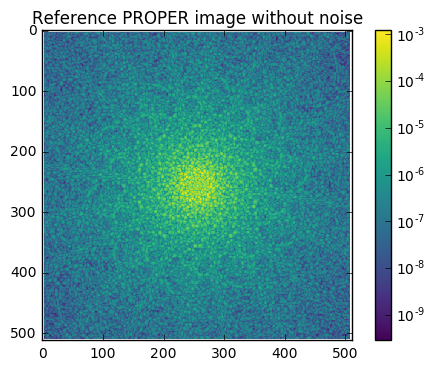

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)

In [6]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*raw_image)**2) 
print(min_err)

19288109.0166


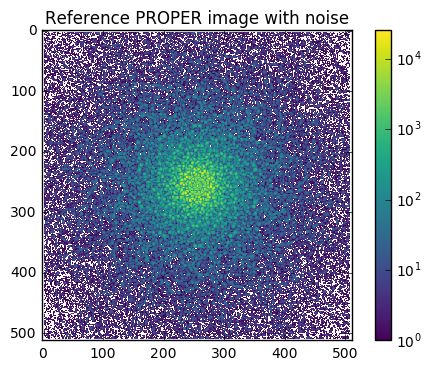

In [7]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

# Fit by tweaking telescope magnification

Let's assume that the model is correct, and that the only parameter that isn't well known is the spacing between the primary and secondary mirrors. Assume also that both the reference and model PSFs are at their corresponding focal planes. Optimise the model to minimise the error between the two detector images.

In [8]:
# Adapted from Barnaby's code for the lens equation 

#Fa = 0.5 * 1.143451
#Fb = -0.5 * 0.0467579189727913
#T = 0.549337630333726
def bfl(fa, fb, d):
    '''Calculate back focal length for a pair of lenses
    
    Parameters
    ----------
    fa: float
    primary lens focal length
    
    fb: float
    secondary lens focal length, in same units as fa
    
    d: float
    separation between primary and secondary lenses, in same units as fa and fb

    Returns
    -------
    Distance from secondary lens to focal plane
    '''
    # 1/f = 1/fa + 1/fb - d/(fa fb)
    f = (1./fa + 1./fb - d/(fa * fb))**-1
    # Assume thin lenses so BFL = F(Fa - T) / Fa
    return f*(fa - d) / fa

In [9]:
# Function to generate 
def model_err(sep, view=False):
    print('Trying with separation ', sep)
    settings = toliman_settings.copy()
    fa = settings['m1_fl']
    fb = settings['m2_fl']
    settings['m1_m2_sep'] = sep 
    b = bfl(fa, fb, sep)
    settings['bfl'] = b
    print('Calculated BFL ', b)
    source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': settings
            }
    im = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        #plt.title('Reference PROPER image with noise')
        plt.show()
    error = np.sum((im - detector_image)**2)
    print('Error ', error)
    return error

## Sanity check

How does error value vary over reasonable range? 

Trying with separation  0.54
Calculated BFL  -0.0888439999999984


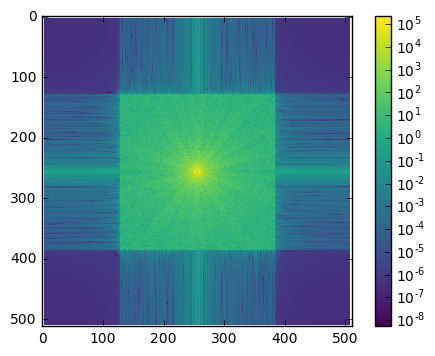

Error  469810057328.0
Trying with separation  0.545
Calculated BFL  -0.18655146268656098


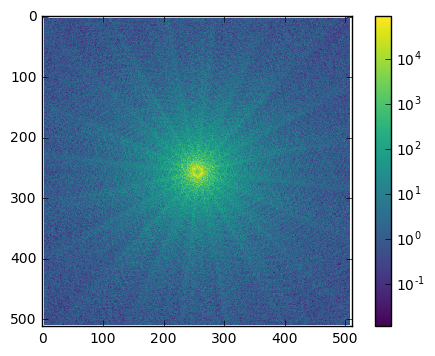

Error  248640236939.0
Trying with separation  0.55
Calculated BFL  0.30790751515152875


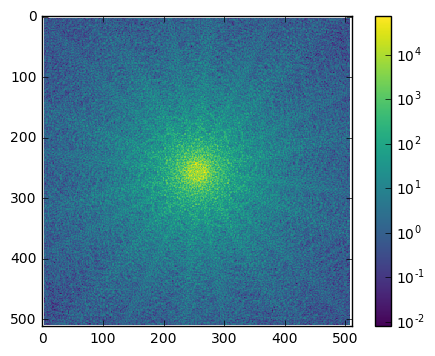

Error  193886724504.0
Trying with separation  0.555
Calculated BFL  0.058819157894737996


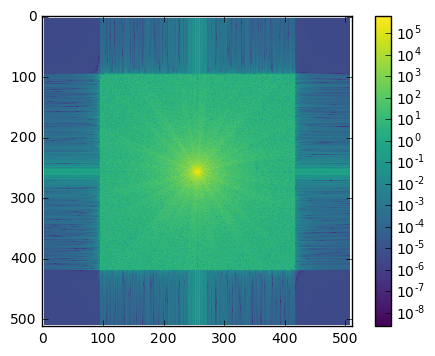

Error  1.95967104697e+12
Trying with separation  0.56
Calculated BFL  0.023540549356223364


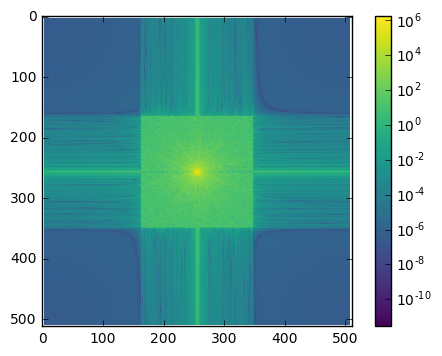

Error  8.75854784986e+12


In [10]:
errors = []
for sep in [0.54, 0.545, 0.55, 0.555, 0.56]:
    errors.append((sep,model_err(sep, view=True)))

In [ ]:
plt.plot(*zip(*errors))
plt.yscale('log')
plt.axhline(y=min_err, color='red')
plt.show()

## Optimize

In [12]:
from scipy.optimize import least_squares
sep_error = 0.01
sep_init = toliman_settings['m1_m2_sep']+sep_error
opt = least_squares(model_err, sep_init)

Trying with separation  [ 0.55924]
Calculated BFL  [ 0.02681508]
Error  8.66540009166e+12
Trying with separation  [ 0.55924001]
Calculated BFL  [ 0.02681501]
Error  8.66546410333e+12
Trying with separation  [ 0.5572228]
Calculated BFL  [ 0.03822677]
Error  3.47585350723e+12
Trying with separation  [ 0.55722281]
Calculated BFL  [ 0.03822667]
Error  3.47589592615e+12
Trying with separation  [ 0.55600178]
Calculated BFL  [ 0.04805755]
Error  3.3613158586e+12
Trying with separation  [ 0.55600179]
Calculated BFL  [ 0.04805741]
Error  3.36134151162e+12
Trying with separation  [ 0.55569652]
Calculated BFL  [ 0.05102585]
Error  2.94335997649e+12
Trying with separation  [ 0.55569654]
Calculated BFL  [ 0.05102569]
Error  2.94337941965e+12
Trying with separation  [ 0.55508602]
Calculated BFL  [ 0.05776951]
Error  2.0644404652e+12
Trying with separation  [ 0.55508603]
Calculated BFL  [ 0.05776933]
Error  2.06445830099e+12
Trying with separation  [ 0.553865]
Calculated BFL  [ 0.07573597]
Error  1.4

In [13]:
# How do things look now?
settings = toliman_settings.copy()
fa = settings['m1_fl']
fb = settings['m2_fl']
sep = opt.x[0]
print("Optimal separation {} differs from target by {}".format(sep, sep-sep_init))
settings['m1_m2_sep'] = sep 
b = bfl(fa, fb, sep)
settings['bfl'] = b
source = {
    'wavelengths': [wavelength],
    'weights': [1.],
        'settings': settings
    }
final = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)

Optimal separation 0.5474537733541313 differs from target by -0.011786226645868814


In [14]:
final *= intensity_scale

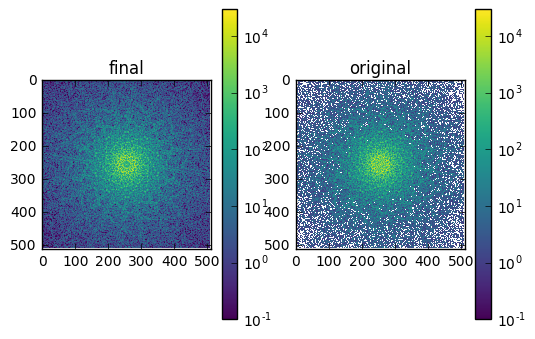

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final, interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image, interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

In [20]:
print("Final error {:.2e} vs. minimum bound of {:.2e}".format(np.sum((detector_image - final)**2), min_err))

Final error 8.96e+09 vs. minimum bound of 1.93e+07


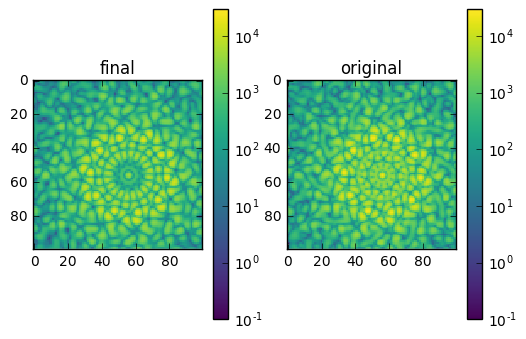

In [17]:
# zoom into central region
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()